In [0]:
# 구글 드라이브와 연동하는 방법 입니다. 
# Google File Drive Stream 접근을 허용해야 합니다.
from google.colab import auth
auth.authenticate_user()

# 구글 드라이브 mount 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

from models.WGAN import WGAN

Using TensorFlow backend.


In [0]:
from keras.datasets import mnist, cifar100,cifar10

def load_cifar(label, num):
    if num == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = 'fine')

    train_mask = [y[0]==label for y in y_train]
    test_mask = [y[0]==label for y in y_test]

    x_data = np.concatenate([x_train[train_mask], x_test[test_mask]])
    y_data = np.concatenate([y_train[train_mask], y_test[test_mask]])

    x_data = (x_data.astype('float32') - 127.5) / 127.5
 
    return (x_data, y_data)

In [0]:
# run params
SECTION = 'gan'
RUN_ID = '0004'
DATA_NAME = 'horses'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER, exist_ok=True)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


## data

In [0]:
if DATA_NAME == 'cars':
    label = 1
elif DATA_NAME == 'horses':
    label = 7
(x_train, y_train) = load_cifar(label, 10)


170500096/170498071 [==============================] - 11s 0us/step


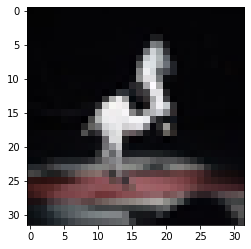

In [0]:
plt.imshow((x_train[30,:,:,:]+1)/2)

## architecture

In [0]:
if mode == 'build':
    gan = WGAN(input_dim = (32,32,3)
            , critic_conv_filters = [32,64,128,128]
            , critic_conv_kernel_size = [5,5,5,5]
            , critic_conv_strides = [2,2,2,1]
            , critic_batch_norm_momentum = None
            , critic_activation = 'leaky_relu'
            , critic_dropout_rate = None
            , critic_learning_rate = 0.00005
            , generator_initial_dense_layer_size = (4, 4, 128)
            , generator_upsample = [2,2, 2,1]
            , generator_conv_filters = [128,64,32,3]
            , generator_conv_kernel_size = [5,5,5,5]
            , generator_conv_strides = [1,1, 1,1]
            , generator_batch_norm_momentum = 0.8
            , generator_activation = 'leaky_relu'
            , generator_dropout_rate = None
            , generator_learning_rate = 0.00005
            , optimiser = 'rmsprop'
            , z_dim = 100
            )
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))


In [0]:
gan.critic.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
critic_conv_2 (Conv2D)       (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 128)         0   

In [0]:
gan.generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 128)         0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 8, 8, 128)         4097

## training

In [0]:
BATCH_SIZE = 128
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5
CLIP_THRESHOLD = 0.01

In [0]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , clip_threshold = CLIP_THRESHOLD
)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: (-0.000)(R -0.001, F 0.000)]  [G loss: -0.001] 


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1001 [D loss: (-0.015)(R -0.015, F -0.015)]  [G loss: 0.035] 
1002 [D loss: (-0.013)(R -0.014, F -0.012)]  [G loss: 0.029] 
1003 [D loss: (-0.012)(R -0.018, F -0.007)]  [G loss: 0.033] 
1004 [D loss: (-0.013)(R -0.008, F -0.017)]  [G loss: 0.038] 
1005 [D loss: (-0.016)(R -0.011, F -0.020)]  [G loss: 0.042] 
1006 [D loss: (-0.012)(R -0.010, F -0.014)]  [G loss: 0.039] 
1007 [D loss: (-0.010)(R -0.011, F -0.010)]  [G loss: 0.033] 
1008 [D loss: (-0.010)(R -0.018, F -0.001)]  [G loss: 0.025] 
1009 [D loss: (-0.014)(R -0.023, F -0.005)]  [G loss: 0.031] 
1010 [D loss: (-0.016)(R -0.032, F -0.000)]  [G loss: 0.025] 
1011 [D loss: (-0.019)(R -0.037, F -0.001)]  [G loss: 0.019] 
1012 [D loss: (-0.020)(R -0.035, F -0.005)]  [G loss: 0.019] 
1013 [D loss: (-0.012)(R -0.035, F 0.012)]  [G loss: 0.012] 
1014 [D loss: (-0.016)(R -0.041, F 0.010)]  [G loss: 0.015] 
1015 [D loss: (-0.021)(R -0.040, F -0.002)]  [G loss: 0.020] 
1016 [D loss: (-0.009)(R -0.033, F 0

In [0]:
gan.sample_images(RUN_FOLDER)

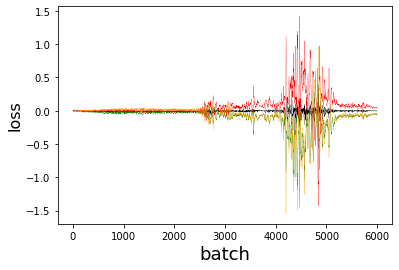

In [0]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

# plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()

In [0]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [0]:

r, c = 5, 5

idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
true_imgs = (x_train[idx] + 1) *0.5

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(true_imgs[cnt], cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))
plt.close()

In [0]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, gan.z_dim))
gen_imgs = gan.generator.predict(noise)

#Rescale images 0 - 1

gen_imgs = 0.5 * (gen_imgs + 1)
# gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))
plt.close()


fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            
            diff = compare_images(gen_imgs[cnt, :,:,:], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))
plt.close()